In [3]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#from sklearn.impute import SimpleImputer

### data_imputada

In [15]:
def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]

In [16]:
archivo= pandas.read_csv("dataimputada2.csv", decimal=".")

In [17]:
archivo.shape

(91713, 200)

In [18]:
result = archivo.isnull().sum()/91713
r = result.sort_values(ascending=True) 
data2 = archivo[r[r<=0.00].reset_index()["index"]].drop(columns=["encounter_id", "readmission_status"]) 
data2.shape

(91713, 119)

In [19]:
data3 =data2.drop(columns=["hospital_death"])
data3.shape

(91713, 118)

## NORMALIZAR LOS DATOS

In [20]:
variables_1=['gcs_motor_apache', 'gcs_eyes_apache', 'gcs_verbal_apache', 'weight', "bmi"
, 'bun_apache', 'creatinine_apache', 'sodium_apache', 'temp_apache', 'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_min', "d1_diasbp_noninvasive_min", "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_noninvasive_max",  "d1_mbp_noninvasive_min", "d1_resprate_max", "d1_resprate_min", "d1_spo2_max", "d1_spo2_min", "d1_sysbp_max", "d1_sysbp_min", "d1_sysbp_noninvasive_max", "d1_sysbp_noninvasive_min", "d1_temp_max", "d1_temp_min", "h1_diasbp_max", "h1_diasbp_min", "h1_diasbp_noninvasive_max", "h1_diasbp_noninvasive_min", "h1_heartrate_max", "h1_heartrate_min", "h1_mbp_max", "h1_mbp_min", "h1_mbp_noninvasive_max", "h1_mbp_noninvasive_min", "h1_resprate_max", "h1_spo2_max", "h1_spo2_min", "h1_sysbp_max", "h1_sysbp_min", "h1_sysbp_noninvasive_max", "h1_sysbp_noninvasive_min", "h1_temp_max", "h1_temp_min", "d1_bun_max", "d1_bun_min", "d1_calcium_max", "d1_calcium_min", "d1_creatinine_max", "d1_creatinine_min", "d1_glucose_max", "d1_glucose_min", "d1_hco3_max", "d1_hco3_min", "d1_hemaglobin_min", "d1_platelets_max", "d1_platelets_min", "d1_potassium_max", "d1_potassium_min", "d1_sodium_min", "d1_wbc_max", "d1_wbc_min", "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob"]
variables_2=['age', 'height',  'hematocrit_apache','map_apache', "d1_mbp_min", "d1_hemaglobin_max", "d1_hematocrit_max", "d1_hematocrit_min", "d1_sodium_max"]

variables_continuas= variables_1+variables_2

# solo las columnas continuas
continuas=[]
for var in variables_continuas:
    if var in list(data2.columns):
        continuas.append(var)
            
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()# Fit on training set only.
dataNorm= scaler.fit_transform(data2[continuas]) 
norm= pd.DataFrame(dataNorm, columns= continuas)


# sin continuas
data_otros= data2.drop(columns= continuas)
        

In [21]:
result = pd.merge(data_otros.reset_index(),
                  norm.reset_index(), 
                  left_index=True, 
                  right_index=True)

data_norm=result.drop(columns=["index_x","patient_id" ])

In [22]:
for var in list(result.columns):
    if var not in list(data2.columns):
        result.drop(columns= var)

### LOGISTIC REGRESSION 

In [23]:
data3 =data_norm.drop(columns=["hospital_death"])
data3.shape

(91713, 119)

In [24]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, data3, data_norm["hospital_death"], scoring='recall', cv=cv, n_jobs=-1)
# summarize performance
print('Mean recall: %.3f' % mean(scores))

Mean recall: 0.735


In [25]:
# con data normalizda
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, data_norm, data2["hospital_death"], scoring='recall', cv=cv, n_jobs=-1)
# summarize performance
print('Mean recall: %.3f' % mean(scores))

Mean recall: 0.746


## Regularizacion
##### https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [27]:
### Es necesario variar el c (esta fijo) 

from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(data2)

X, y = train[train.columns.drop("hospital_death")], train['hospital_death']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1,penalty="l2", random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

TypeError: 'NoneType' object is not iterable

In [241]:
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]
len(selected_columns)

31

### Evaluacion  con las variables seleccionadas   de regularizacion

In [116]:
variables_selecc=list(selected_columns)
matriz= data_norm[variables_selecc]


from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, matriz, data2["hospital_death"], scoring='recall', cv=cv, n_jobs=-1)
# summarize performance
print('Mean recall: %.3f' % mean(scores))


Mean recall: 0.695


## codigo random

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
# X es la 10x10 matrix de Hilbert
X = data3
y = data2["hospital_death"]
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
coefs = []
for a in alphas: 
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
# mostramos resultados
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Coeficientes de cresta en función de la regularización')
plt.axis('tight')


c:\users\inspiron\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.62843e-25): result may not be accurate.
  overwrite_a=True).T
c:\users\inspiron\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.78527e-25): result may not be accurate.
  overwrite_a=True).T
c:\users\inspiron\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.01652e-25): result may not be accurate.
  overwrite_a=True).T
c:\users\inspiron\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.17462e-25): result may not be accurate.
  overwrite_a=True).T
c:\users\inspiron\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWar

(0.025118864315095794,
 3.9810717055349695e-11,
 -0.2294903377930254,
 0.13893041045974475)

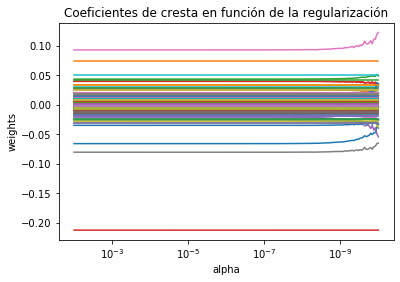

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
# X es la 10x10 matrix de Hilbert
X = data3
y = data2["hospital_death"]
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
coefs = []
for a in alphas: 
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
# mostramos resultados
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Coeficientes de cresta en función de la regularización')
plt.axis('tight')


###  regularizacion 3

In [29]:
from sklearn import datasets
import numpy as np
X = data3
y = data2["hospital_death"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


/media/mdleiton/Respaldo/repositorios/env/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/media/mdleiton/Respaldo/repositorios/env/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

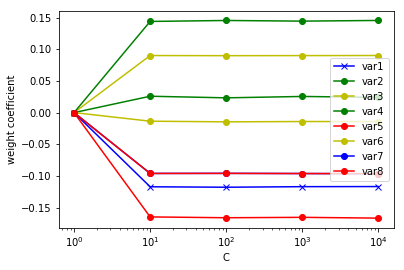

In [30]:
from sklearn.linear_model import LogisticRegression

weights, params = [], []
for c in np.arange(1e-15,5):
    lr = LogisticRegression(C=10*c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append((lr.coef_)[0])
    params.append(10**c)

weights = np.array(weights)

# Decision region drawing
import matplotlib.pyplot as plt

plt.plot(params, weights[:, 0], color='blue', marker='x', label='var1')
plt.plot(params, weights[:, 1], color='green',  marker='o', label='var2')
plt.plot(params, weights[:, 2], color='y',  marker='o', label='var3')
plt.plot(params, weights[:, 3], color='green',  marker='o', label='var4')
plt.plot(params, weights[:, 4], color='r',  marker='o', label='var5')
plt.plot(params, weights[:, 5], color='y',  marker='o', label='var6')
plt.plot(params, weights[:, 6], color='b',  marker='o', label='var7')
plt.plot(params, weights[:, 6], color='r',  marker='o', label='var8')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='right')
plt.xscale('log')
plt.show()

In [235]:
len(params)

5

## REGULARIZACION 4 
#### https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [32]:
data4= data_norm

#### 3. Selecting Numerical Columns

In [33]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data4.select_dtypes(include=numerics).columns)
data4 = data4[numerical_vars]
data4.shape

(91713, 122)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    data4.drop(labels=['hospital_death'], axis=1),
    data4['hospital_death'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((64199, 121), (27514, 121))

In [35]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2', class_weight="balanced"))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 121
selected features: 39
features with coefficients shrank to zero: 0


/media/mdleiton/Respaldo/repositorios/env/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
### Grafico
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

score=[]
for c in np.arange(1e-15,7):
    model = LogisticRegression( C=10*c,solver='lbfgs', class_weight='balanced')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, data_norm, data2["hospital_death"], scoring='recall', cv=cv, n_jobs=-1)
    score.append( mean(scores))


In [39]:
ys= []
for i in np.arange(1e-15,7):
    ys.append(10*i)
    

In [49]:
print(score)
print(ys)
print(selected_feat)
print(sel_.estimator_.coef_)

[0.21574217735722162, 0.7423471972144536, 0.7367440736909764, 0.7454626330732528, 0.7474423437919012, 0.743816855874378, 0.7459241062117169]
[1.0000000000000002e-14, 10.00000000000001, 20.000000000000007, 30.000000000000007, 40.00000000000001, 50.00000000000001, 60.00000000000001]
Index(['apache_3j_bodysystem_8', 'apache_3j_bodysystem_5',
       'apache_2_bodysystem_3', 'apache_2_bodysystem_6',
       'apache_3j_bodysystem_2', 'apache_3j_bodysystem_0', 'ventilated_apache',
       'apache_post_operative', 'apache_3j_diagnosis', 'pre_icu_los_days',
       'icu_id', 'elective_surgery', 'apache_2_bodysystem_9', 'index_y',
       'gcs_motor_apache', 'bun_apache', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_mbp_max', 'd1_mbp_noninvasive_max',
       'd1_spo2_min', 'd1_sysbp_noninvasive_min', 'd1_temp_min',
       'h1_heartrate_max', 'h1_mbp_min', 'h1_mbp_noninvasive_min',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_min', 'd1_bun_min',
       'd1_creatinine_max', 'd1_hemaglob

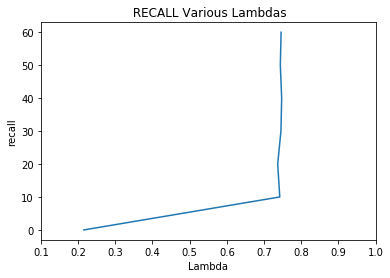

In [47]:
plt.plot(score, ys )
plt.xlim(0.10,1,0)
plt.xlabel('Lambda')
plt.ylabel('recall')
plt.title(' RECALL Various Lambdas')
plt.show()